# Agents:
These simulations evaluate several agents exploring the thread the needle enviroment

In [1]:
%load_ext autoreload
%autoreload 2
# from IPython.display import display, HTML
# display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
%matplotlib inline
import sys
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from state_inference.gridworld_env import CnnWrapper, OpenEnv, ThreadTheNeedleEnv
from state_inference.utils.training_utils import  parse_config
from state_inference.utils.pytorch_utils import DEVICE
from state_inference.model.agents import RecurrentStateInf

print(f"python {sys.version}")
print(f"torch {torch.__version__}")
print(f"device = {DEVICE}")


python 3.10.11 (main, Apr 20 2023, 13:58:42) [Clang 14.0.6 ]
torch 2.0.1
device = mps


In [3]:
CONFIG_FILE = "state_inference/env_config.yml"
TASK_NAME = "thread_the_needle"
TASK_CLASS = ThreadTheNeedleEnv

In [4]:
env_kwargs, training_kwargs = parse_config(TASK_NAME, CONFIG_FILE)

training_kwargs["n_train_steps"] = 50000
training_kwargs["n_epochs"] = 1

# create the task
task = CnnWrapper(TASK_CLASS.create_env(**env_kwargs))

pi, _ = task.get_optimal_policy()
training_kwargs["optimal_policy"] = pi

  0%|          | 0/1000 [00:00<?, ?it/s]

In [5]:
from state_inference.model.vae import (
    DEVICE,
    GruEncoder,
    Decoder,
    RecurrentStateVae,
)

### Model + Training Parameters
N_EPOCHS = 20  # should be 20
EMBEDDING_LAYERS = 5
MAX_SEQUENCE_LEN = 10
N_ACTIONS = 4
EMBEDDING_DIM = len(task.observation_model.states) // 2
OBSERVATION_DIM = task.observation_model.map_height**2
LR = 3e-4
beta = 1.0
tau = 2.0
gamma = 0.99
dropout = 0.0

optim_kwargs = dict(lr=LR)

# create the model
encoder_hidden = [OBSERVATION_DIM // 5, OBSERVATION_DIM // 10]
decoder_hidden = [OBSERVATION_DIM // 10, OBSERVATION_DIM // 5]
z_dim = EMBEDDING_DIM * EMBEDDING_LAYERS


def make_model():
    encoder = GruEncoder(
        OBSERVATION_DIM,
        encoder_hidden,
        z_dim,
        N_ACTIONS,
        dropout=dropout,
    )
    decoder = Decoder(z_dim, decoder_hidden, OBSERVATION_DIM, dropout=dropout)

    vae_kwargs = dict(
        z_dim=EMBEDDING_DIM, z_layers=EMBEDDING_LAYERS, beta=beta, tau=tau, gamma=gamma
    )

    vae_model = RecurrentStateVae(encoder, decoder, **vae_kwargs).to(DEVICE)
    # print(vae_model)

    agent = RecurrentStateInf(
        task, vae_model, set_action=set(range(4)), optim_kwargs=optim_kwargs
    )
    return agent


agent = make_model()

TypeError: ModelBase.configure_optimizers() takes from 1 to 2 positional arguments but 3 were given

In [ ]:
agent.learn(10000, estimate_batch=False)

In [7]:
from state_inference.utils.data import RecurrentVaeDataset
import torch.nn.functional as F

dataset = RecurrentVaeDataset(
    observations=torch.stack([obs.obs for obs in agent.cached_obs]),
    actions=F.one_hot(torch.tensor([obs.a for obs in agent.cached_obs])),
    max_sequence_len=10,
)

In [8]:
# loader = torch.utils.data.DataLoader(
#     dataset, batch_size=64, collate_fn=dataset.collate_fn
#     )
loader = RecurrentVaeDataset.contruct_dataloader(
    observations=torch.stack([obs.obs for obs in agent.cached_obs]),
    actions=F.one_hot(torch.tensor([obs.a for obs in agent.cached_obs])),
    max_sequence_len=10,
    batch_size=64,
)


b = next(iter(loader))

In [9]:
b[0][0].shape

torch.Size([64, 10, 40, 40, 1])

In [11]:
from state_inference.model.vae import GruEncoder

encoder = GruEncoder(
    OBSERVATION_DIM, encoder_hidden, z_dim, N_ACTIONS, batch_first=True
)


with torch.no_grad():
    obs, actions = b[0]
    x = encoder(torch.flatten(obs, start_dim=2), actions)

In [12]:
x.shape

torch.Size([64, 1000])

In [19]:
obs[:, -1, ...].shape

torch.Size([64, 40, 40, 1])

In [75]:
o0.shape

torch.Size([10, 40, 40, 1])

In [8]:
from state_inference.utils.training_utils import get_policy_prob

pmf = get_policy_prob(
    agent,
    n_states=env_kwargs["n_states"],
    map_height=env_kwargs["map_height"],
    cnn=True,
)
pmf

/Users/nicholasfranklin/Projects/StateInference/state_inference/utils/pytorch_utils.py:157: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x, dtype=float)


array([[0.00636734, 0.63911302, 0.00636734, 0.3481523 ],
       [0.00636734, 0.63911302, 0.00636734, 0.3481523 ],
       [0.95511155, 0.03057712, 0.00696564, 0.00734568],
       ...,
       [0.67031533, 0.01410269, 0.29622965, 0.01935234],
       [0.67031533, 0.01410269, 0.29622965, 0.01935234],
       [0.67031533, 0.01410269, 0.29622965, 0.01935234]])

Text(0.5, 0.98, 'Value Iteration Agent Learned Policy')

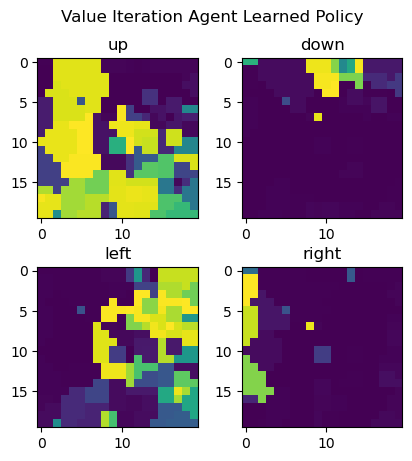

In [9]:
import seaborn as sns

fig, axes = plt.subplots(2, 2)
h, w = env_kwargs["height"], env_kwargs["width"]

axes[0][0].imshow(pmf[:, 0].reshape(h, w))
axes[0][1].imshow(pmf[:, 1].reshape(h, w))
axes[1][0].imshow(pmf[:, 2].reshape(h, w))
axes[1][1].imshow(pmf[:, 3].reshape(h, w))


axes[0][0].set_title("up")
axes[0][1].set_title("down")
axes[1][0].set_title("left")
axes[1][1].set_title("right")

plt.subplots_adjust(hspace=0.3, wspace=-0.3)

plt.suptitle("Value Iteration Agent Learned Policy")

In [10]:
agent.value_function

{135348128614: 417.3419860578188,
 176877654445: 424.4461253094256,
 90841843979: 418.34731220043994,
 177499855771: 427.15243487311284,
 216174354933: 431.568324604071,
 255937305261: 429.4321784573461,
 37990143356: 441.76417029101464,
 306221729036: 446.32765330902237,
 150794190357: 437.99143694001026,
 237361239049: 423.2369702315084,
 204581491964: 431.8615253797298,
 54930996893: 425.3642095076729,
 167159815512: 432.20685124196126,
 211570664844: 421.7399281713408,
 212002663124: 417.42232240470986,
 130302028690: 414.83070487865444,
 298313266428: 418.33314968904864,
 58021706709: 410.3443357777636,
 74238936593: 414.65378190286935,
 122694258292: 403.7113641726986,
 165703686537: 400.9737318708538,
 290572325104: 405.68911564703524,
 102724032196: 401.65527470344307,
 102721192089: 399.91867943689687,
 61060500003: 399.409132460345,
 186901931546: 410.9608162161199,
 157011658496: 414.8760733424109,
 189338378151: 410.86303344734716,
 177737657936: 403.3066077668857,
 2716014

In [11]:
np.sum(pi * pmf, axis=1).mean()

0.6369507139397117

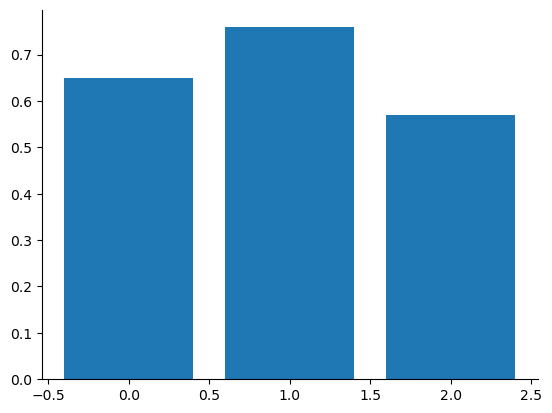

In [12]:
room_1_mask = (np.arange(400) < 200) * (np.arange(400) % 20 < 10)
room_2_mask = (np.arange(400) >= 200) * (np.arange(400) % 20 < 10)
room_3_mask = np.arange(400) % 20 >= 10

score_room_1 = np.sum(pi[room_1_mask] * pmf[room_1_mask], axis=1).mean()
score_room_2 = np.sum(pi[room_2_mask] * pmf[room_2_mask], axis=1).mean()
score_room_3 = np.sum(pi[room_3_mask] * pmf[room_3_mask], axis=1).mean()
plt.bar([0, 1, 2], [score_room_1, score_room_2, score_room_3])

sns.despine()

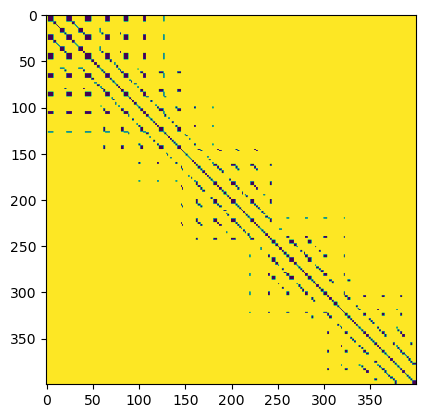

In [13]:
from state_inference.utils.pytorch_utils import make_tensor, convert_8bit_to_float
from sklearn.metrics import pairwise_distances

obs = convert_8bit_to_float(
    torch.stack(
        [
            make_tensor(task.observation_model(s))
            for s in range(task.transition_model.n_states)
            for _ in range(1)
        ]
    )
).to(DEVICE)
z = agent.state_inference_model.get_state(obs)

hash_vector = np.array(
    [
        agent.state_inference_model.z_dim**ii
        for ii in range(agent.state_inference_model.z_layers)
    ]
)

z = z.dot(hash_vector)
d = pairwise_distances(z.reshape(-1, 1), metric=lambda x, y: x == y)
plt.imshow(1 - d)

In [14]:
euc = pairwise_distances(
    [(x, y) for x in range(20) for y in range(20)],
    # metric=lambda x, y: np.sqrt((x[0] - y[0]) ** 2 + (x[1] - y[1]) ** 2),
    metric=lambda x, y: np.abs(x[0] - y[0]) + np.abs(x[1] - y[1]),
)

d_w_wall = np.mean([d[s1][s2] for s1, s2 in task.transition_model.walls])
print(f"Distance between neighboring states sepearted by a wall     {d_w_wall}")


wall_mask = np.zeros((task.n_states, task.n_states))
for s0, s1 in task.transition_model.walls:
    wall_mask[s0][s1] = 1.0
    wall_mask[s1][s0] = 1.0


d_wo_wall = d.reshape(-1)[(wall_mask.reshape(-1) == 0) & (euc.reshape(-1) == 1)].mean()
print(f"Distance between neighboring states NOT sepearted by a wall {d_wo_wall}")

Distance between neighboring states sepearted by a wall     0.7857142857142857
Distance between neighboring states NOT sepearted by a wall 0.5423497267759563


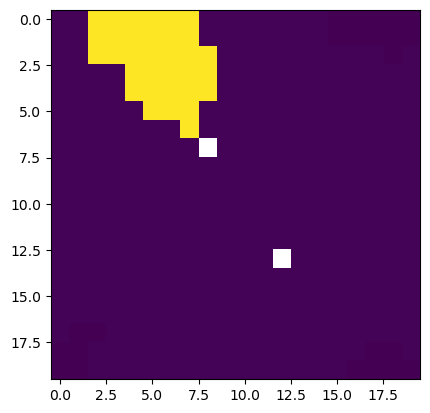

In [15]:
# agent._estimate_reward_model()

rews = np.array([agent.reward_estimator.get_reward(z0) for z0 in z]).reshape(20, 20)
plt.imshow(rews)

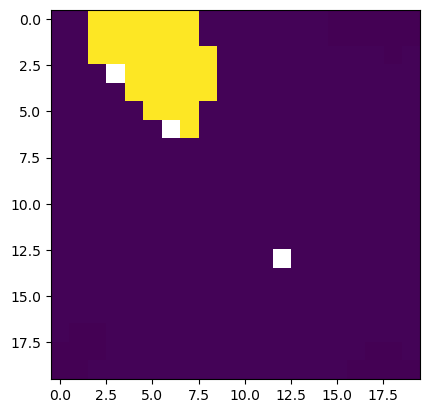

In [16]:
obs = convert_8bit_to_float(
    torch.stack(
        [
            make_tensor(task.observation_model(s))
            for s in range(task.transition_model.n_states)
            for _ in range(1)
        ]
    )
).to(DEVICE)
z = agent.state_inference_model.get_state(obs)

hash_vector = np.array(
    [
        agent.state_inference_model.z_dim**ii
        for ii in range(agent.state_inference_model.z_layers)
    ]
)

z = z.dot(hash_vector)

rews = np.array([agent.reward_estimator.get_reward(z0) for z0 in z]).reshape(20, 20)
plt.imshow(rews)

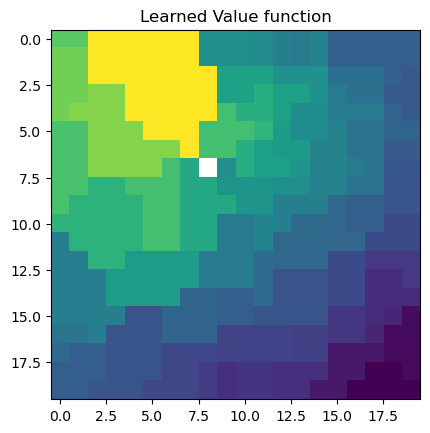

In [36]:
def get_value_function(model, task):
    obs = convert_8bit_to_float(
        torch.stack(
            [
                make_tensor(task.observation_model(s))
                for s in range(task.transition_model.n_states)
                for _ in range(1)
            ]
        )
    ).to(DEVICE)
    z = model.state_inference_model.get_state(obs)

    hash_vector = np.array(
        [
            model.state_inference_model.z_dim**ii
            for ii in range(agent.state_inference_model.z_layers)
        ]
    )

    z = z.dot(hash_vector)

    value_function = np.array(
        [agent.value_function.get(z0, np.nan) for z0 in z]
    ).reshape(20, 20)
    return value_function


v = get_value_function(agent, task)
plt.title("Learned Value function")
plt.imshow(v)

In [51]:
from tqdm import trange


## Repeat with iterations
n_models = 25


room_1_mask = (np.arange(400) < 200) * (np.arange(400) % 20 < 10)
room_2_mask = (np.arange(400) >= 200) * (np.arange(400) % 20 < 10)
room_3_mask = np.arange(400) % 20 >= 10


scores = []
value_functions = []


for idx in trange(n_models):
    agent = make_model()
    agent.learn(total_timesteps=training_kwargs["n_train_steps"], progress_bar=False)
    # agent.learn(total_timesteps=500, progress_bar=False)

    pmf = get_policy_prob(
        agent,
        n_states=env_kwargs["n_states"],
        map_height=env_kwargs["map_height"],
        cnn=True,
    )

    score_room_1 = np.sum(pi[room_1_mask] * pmf[room_1_mask], axis=1).mean()
    score_room_2 = np.sum(pi[room_2_mask] * pmf[room_2_mask], axis=1).mean()
    score_room_3 = np.sum(pi[room_3_mask] * pmf[room_3_mask], axis=1).mean()

    v = get_value_function(agent, task)

    scores.append(
        pd.DataFrame(
            {
                "Iteration": [idx] * 4,
                "Score": [
                    np.sum(pi * pmf, axis=1).mean(),
                    score_room_1,
                    score_room_2,
                    score_room_3,
                ],
                "Condition": ["Overall", "Room 1", "Room 2", "Room 3"],
            }
        )
    )

    value_functions.append(
        pd.DataFrame(
            {
                "Iteration": [idx] * task.n_states,
                "State-Values": v.reshape(-1),
                "States": np.arange(task.n_states),
            }
        )
    )

scores = pd.concat(scores)
value_functions = pd.concat(value_functions)

  0%|          | 0/25 [00:00<?, ?it/s]/Users/nicholasfranklin/Projects/StateInference/state_inference/utils/pytorch_utils.py:157: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x, dtype=float)
  4%|▍         | 1/25 [12:25<4:58:01, 745.06s/it]/Users/nicholasfranklin/Projects/StateInference/state_inference/utils/pytorch_utils.py:157: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x, dtype=float)
  8%|▊         | 2/25 [24:22<4:39:19, 728.67s/it]/Users/nicholasfranklin/Projects/StateInference/state_inference/utils/pytorch_utils.py:157: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clo

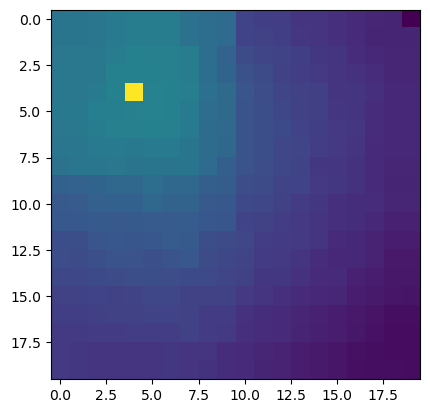

In [52]:
plt.imshow(
    value_functions.groupby("States")["State-Values"]
    .apply(np.nanmean)
    .values.reshape(20, 20)
)
value_functions.to_csv("value_functions_stateinf.csv")

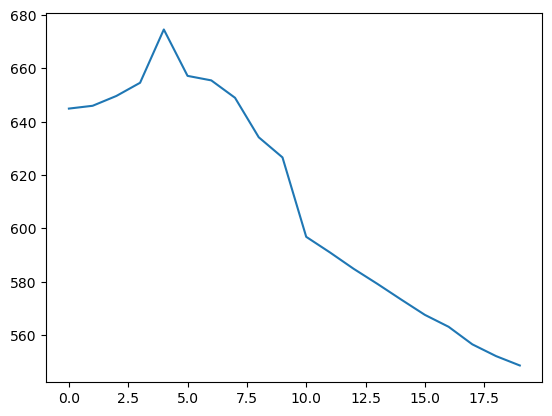

In [66]:
plt.plot(
    value_functions.groupby("States")["State-Values"]
    .apply(np.nanmean)
    .values.reshape(20, 20)[:10, :]
    .mean(axis=0)
)

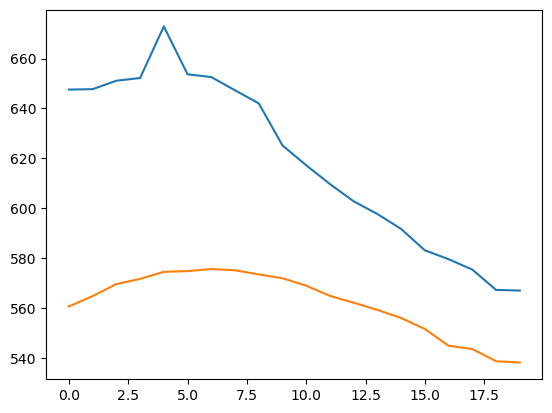

In [69]:
plt.plot(
    value_functions.groupby("States")["State-Values"]
    .apply(np.nanmean)
    .values.reshape(20, 20)[:, :10]
    .mean(axis=1)
)
plt.plot(
    value_functions.groupby("States")["State-Values"]
    .apply(np.nanmean)
    .values.reshape(20, 20)[:, 10:]
    .mean(axis=1)
)

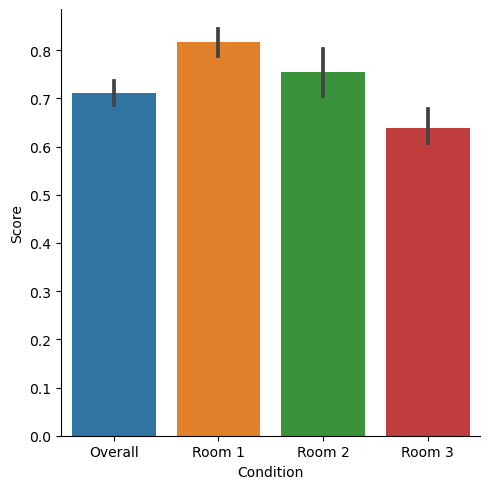

In [53]:
sns.catplot(data=scores, y="Score", x="Condition", kind="bar")

(0.0, 1.0)

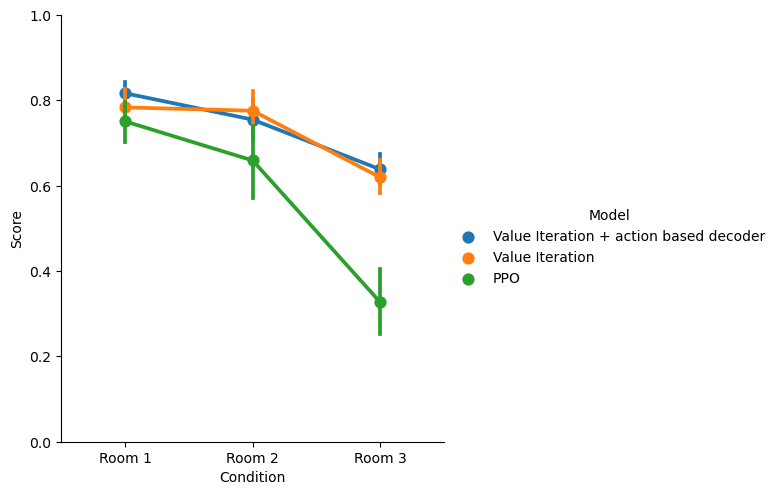

In [54]:
scores.to_csv("sims_thread_the_needle_state_inf.csv")
scores["Model"] = "Value Iteration + action based decoder"
scores2 = pd.read_csv("sims_thread_the_needle_vi_agent.csv")
scores2["Model"] = "Value Iteration"
scores3 = pd.read_csv("sims_thread_the_needle.csv")
scores3["Model"] = "PPO"


all_scores = pd.concat([scores, scores2, scores3])
sns.catplot(
    data=all_scores[all_scores["Condition"] != "Overall"],
    y="Score",
    x="Condition",
    kind="point",
    hue="Model",
)
plt.gca().set_ylim([0, 1])

In [55]:
all_scores.groupby("Model").mean()

/var/folders/fm/4kcsh05n3y34x3qkmmlmn6900000gn/T/ipykernel_46874/2534149237.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  all_scores.groupby("Model").mean()


,Iteration,Score,Unnamed: 0
Model,,,
PPO,24.5,0.563136,1.5
Value Iteration,7.0,0.719600,1.5
Value Iteration + action based decoder,12.0,0.730403,NaN


(0.0, 1.0)

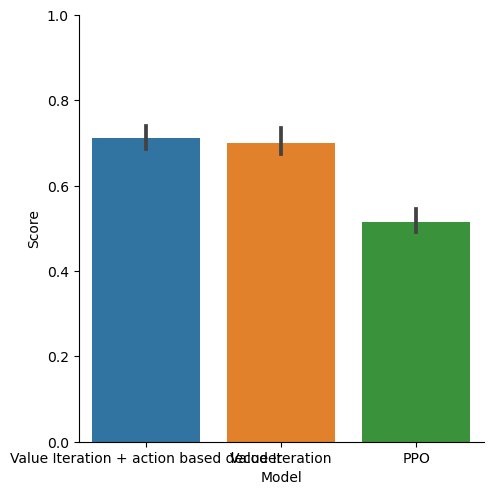

In [56]:
sns.catplot(
    data=all_scores[all_scores["Condition"] == "Overall"],
    y="Score",
    x="Model",
    kind="bar",
)
plt.gca().set_ylim([0, 1])